In [1]:
import pickle
import numpy as np

tsdir = '/home/anton/Documents/Tulane/Research/PNC_Good/'
demofile = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/demographics.pkl'
tsdict = dict()

for task in ['rest', 'nback', 'emoid']:
    item = pickle.load(open(f'{tsdir}/PNC_SPM_{task}_good_filt.pkl', 'rb'))
    tsdict[task] = item
    
sex = [] 
age = []
race = []
wrat = []
subs = []
rest = []
nback = []
emoid = []

demo = pickle.load(open(demofile, 'rb'))

for sub in demo['age_at_cnb']:
    try:
        tsr = tsdict['rest'][sub]
        tsn = tsdict['nback'][sub]
        tse = tsdict['emoid'][sub]
        a = demo['age_at_cnb'][sub]
        s = demo['Sex'][sub] == 'M'
        r = demo['Race'][sub] == 'AA'
        try:
            w = demo['WRAT_CR_STD'][sub]
        except:
            w = 100
        if demo['Race'][sub] not in ['AA', 'EA']:
            continue
    except:
        continue
    rest.append(tsr)
    nback.append(tsn)
    emoid.append(tse)
    age.append(a)
    sex.append(s)
    race.append(r)
    wrat.append(w)
    subs.append(sub)

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
age = np.array(age)
wrat = np.array(wrat)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [rest, nback, emoid, age, sex, race]])

[(1193, 264, 124), (1193, 264, 231), (1193, 264, 210), (1193,), (1193,), (1193,)]


In [54]:
import itertools
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())
        
    def project(self):
        with torch.no_grad():
            self.w[self.w < 0] = 1e-5

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)

def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

mseLoss = nn.MSELoss()

# Parameters
ntrain = 400 #rest.shape[0]
nbatch = 30
smooth_mult = 0.1
nEpochs = 30
pPeriod = 1
ncodes = 800

rest_norm = emoid/np.linalg.norm(emoid, ord=2, axis=-1, keepdims=True)

# Timeseries
xtr, xt = train_test_split(rest_norm, train_size=ntrain)
xtr = torch.from_numpy(xtr).float().cuda()

print(f'Starting ncodes {ncodes}')

# Codebook and weights
lrc = LowRankCodes(ncodes*[1])
lrw = LowRankWeights(ntrain, ncodes, xtr.shape[-1])

# Optimizers
optim = torch.optim.Adam(itertools.chain(
    lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)

t0 = time.time()

for epoch in range(nEpochs):
    for bstart in range(0,ntrain,nbatch):
            bend = bstart+nbatch
            if bend > ntrain:
                bend = ntrain
            optim.zero_grad()
            book = lrc()
            recon_loss = 0
            smooth_loss_fc = 0
            for subidx in range(bstart, bend):
                xsub = get_sub_fc(xtr[subidx])
                xhat = lrw(subidx, book)   
                recon_loss += get_recon_loss(xsub, xhat)
                smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
            recon_loss /= (bend-bstart)
            smooth_loss_fc /= (bend-bstart)
            loss = recon_loss+smooth_loss_fc
            loss.backward()
            optim.step()
            sched.step(loss)
            lrw.project()
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc]]} '
              f'lr: {sched._last_lr}')

t1 = time.time()
print(f'Completed dictionary estimation {t1-t0} sec')

Starting ncodes 800
0 390 recon: [0.008935318257320371, 3.823028915616008e-06] lr: [0.01]
1 390 recon: [0.008924733929077586, 4.643578279569039e-06] lr: [0.01]
2 390 recon: [0.008871204594314782, 1.1942291234581598e-05] lr: [0.01]
3 390 recon: [0.008679984656740067, 0.0001122728403000253] lr: [0.01]
4 390 recon: [0.00819217584107308, 0.0005988609858182785] lr: [0.01]
5 390 recon: [0.00789254964268989, 0.001827379352773997] lr: [0.01]
6 390 recon: [0.007974323311719381, 0.0010822829608859] lr: [0.01]
7 390 recon: [0.0078047592028351745, 0.0018861681207635256] lr: [0.01]
8 390 recon: [0.007765266519722892, 0.0018061458588367978] lr: [0.01]
9 390 recon: [0.0076116998040200515, 0.001426743950293431] lr: [0.0075]
10 390 recon: [0.0073567250242080025, 0.0016712094136666817] lr: [0.005625]
11 390 recon: [0.007327665570947654, 0.0014961277052515463] lr: [0.005625]
12 390 recon: [0.007247310160625511, 0.0015991727095156156] lr: [0.005625]
13 390 recon: [0.007206882167791968, 0.00159340564330518

KeyboardInterrupt: 

In [44]:
# Nonneg Elastic Leastsquares

class ElasticNet(nn.Module):
    def __init__(self, AA, AB, l1, l2):
        super(ElasticNet, self).__init__()
        self.AA = AA
        self.AB = AB
        self.w = nn.Parameter(torch.rand(AB.shape[0],AA.shape[1],AB.shape[-1]).float().cuda())
        self.l1 = l1
        self.l2 = l2
        
    def project(self):
        with torch.no_grad():
            self.w[self.w < 0] = 1e-5
        
    def train(self, lr=1e-1, nepochs=2000, pperiod=100, verbose=True):
        mseLoss = nn.MSELoss()
        optim = torch.optim.Adam([self.w], lr=lr, weight_decay=self.l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        for epoch in range(nepochs):
            optim.zero_grad()
            ABhat = torch.matmul(self.AA.detach(),F.relu(self.w))
            loss = mseLoss(ABhat, self.AB.detach())**0.5
            l1loss = self.l1*torch.mean(torch.abs(self.w))
            totloss = loss+l1loss
            totloss.backward()
            optim.step()
            sched.step(totloss)
            self.project()
            if not verbose:
                continue
            if epoch % pperiod == 0 or epoch == nepochs-1:
                print(f'{epoch} {[float(ls) for ls in [loss, l1loss]]} {sched._last_lr}')
        if verbose:
            print('Complete')

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0).detach()
AA = A.T@A
AB = []

x2 = torch.from_numpy(rest_norm).float().cuda()

for sub in range(x2.shape[0]):
    B = get_sub_fc(x2[sub]).reshape(-1, x2.shape[-1])
    AB.append(A.T@B)

AB = torch.stack(AB)
net = ElasticNet(AA.unsqueeze(0), AB, 0, 1e-5)
net.train(nepochs=400, lr=1e-1)

0 [105.42764282226562, 0.0] [0.1]
100 [0.23374661803245544, 0.0] [0.1]
200 [0.12385254353284836, 0.0] [0.031640625000000006]
300 [0.12266513705253601, 0.0] [0.0177978515625]
399 [0.12264672666788101, 0.0] [0.0017817948013544084]
Complete


In [55]:
# Weight estimation
x2 = torch.from_numpy(rest_norm).float().cuda()

book = lrc()
nsubs = x2.shape[0]
nt = x2.shape[-1]

A = book.reshape(book.shape[0], -1).permute(1,0) # nFc x nt
AA = A.T@A
codes = []

for sub in range(nsubs):
    B = get_sub_fc(x2[sub]).reshape(-1, nt)
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')

codes = torch.stack(codes)
print(codes.shape)
print('Finished weight estimation')

Finished 0 0.004747387487441301
Finished 100 0.00447112089022994
Finished 200 0.004597866907715797
Finished 300 0.004343549255281687
Finished 400 0.007142397575080395
Finished 500 0.005646524019539356
Finished 600 0.006676574237644672
Finished 700 0.004446085542440414
Finished 800 0.005710417404770851
Finished 900 0.005245561245828867
Finished 1000 0.005309580825269222
Finished 1100 0.004605982918292284
torch.Size([1193, 800, 210])
Finished weight estimation


In [24]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


[184 285 683 735 697 296 345 255 492 124]


/tmp/ipykernel_45335/4104764782.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


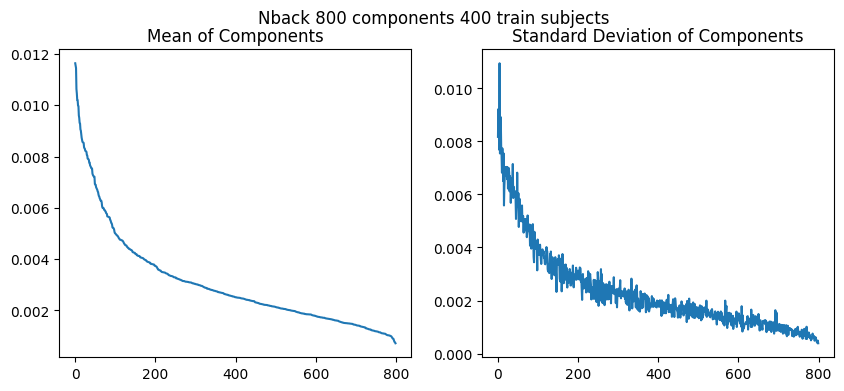

In [56]:
import matplotlib.pyplot as plt

codesmu = np.mean(codes.detach().cpu().numpy(), axis=-1)
# codesmu = np.mean(lrw.w.detach().cpu().numpy(), axis=-1)
# codesmu = np.mean(net.w.detach().cpu().numpy(), axis=-1)
codesmuabs = np.abs(codesmu)
cmu = np.mean(codesmuabs, axis=0)
csig = np.std(codesmuabs, axis=0)
cmin = cmu.min()
cmax = cmu.max()

idcs = np.argsort(cmu)[::-1]
print(idcs[:10])

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(cmu[idcs])
ax[0].set_title('Mean of Components')
ax[1].plot(csig[idcs])
ax[1].set_title('Standard Deviation of Components')
fig.suptitle(f'Nback {ncodes} components {ntrain} train subjects')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/DynamicDict/Figures/components.pdf')
fig.show()

In [57]:
def corr(x, y):
    x = x-np.mean(x, axis=0, keepdims=True)
    y = y-np.mean(y)
    xx = np.einsum('ab,ab->b', x, x)
    yy = np.einsum('a,a->', y, y)
    xy = np.einsum('ab,a->b', x, y)
    rho = xy/np.sqrt(xx*yy)
    return rho

age_corr = corr(codesmu, age)
sex_corr = corr(codesmu, sex)
race_corr = corr(codesmu, race)
wrat_corr = corr(codesmu, wrat)

print([(a.min(), a.max()) for a in [age_corr, sex_corr, race_corr, wrat_corr]])

[(-0.26340094987244894, 0.35655137394837655), (-0.21405198129950875, 0.18456327850941553), (-0.24219571568938686, 0.2904716749687184), (-0.15492707470477313, 0.16542344758173372)]


[130, 564, 583, 419, 674, 629, 294, 553, 757, 578] [-0.21405198 -0.21118878 -0.1947528  -0.18916163 -0.18908415 -0.18724222
 -0.18387835 -0.18294876 -0.1796016  -0.17782599]
[538, 350, 191, 542, 694, 572, 177, 595, 546, 580] [0.18456328 0.16315444 0.13736764 0.12648532 0.12417144 0.12031663
 0.11526311 0.11148538 0.10904743 0.1080513 ]


/tmp/ipykernel_45335/4245531403.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


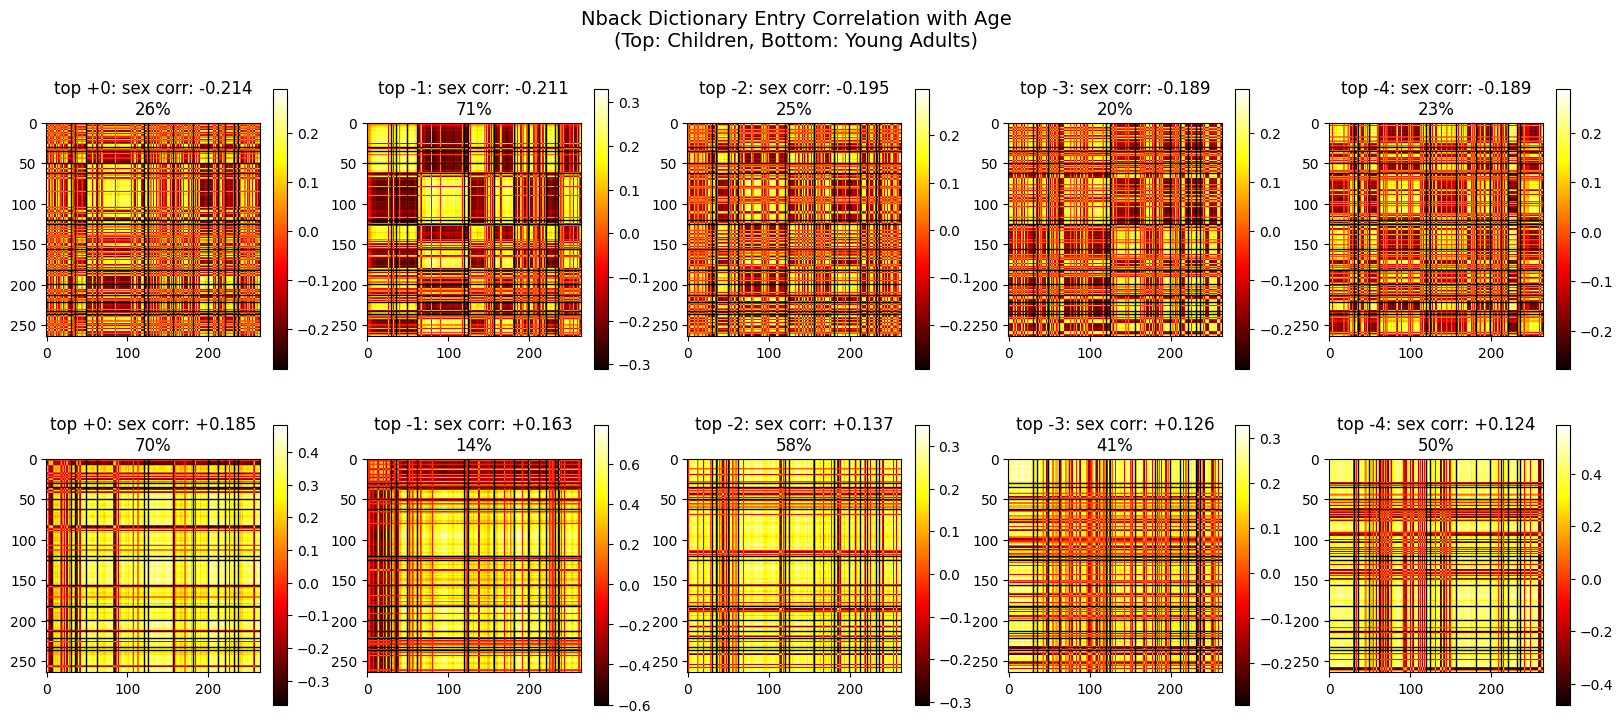

In [63]:
pheno_corr = sex_corr
field = 'sex'

idcs = np.argsort(pheno_corr)
top = [] #idcs[-5:]
bottom = [] #idcs[:5]

for i in range(len(idcs)):
    j = idcs[i]
    if cmu[j] > 0.2*cmax:
        bottom.append(j)
    if len(bottom) == 10:
        break
        
for i in range(len(idcs)):
    j = idcs[len(idcs)-i-1]
    if cmu[j] > 0.05*cmax: 
        top.append(j)
    if len(top) == 10:
        break
        
print(bottom, pheno_corr[np.array(bottom)])
print(top, pheno_corr[np.array(top)])

es = [30,  35,  49,  62, 120, 125, 156, 181, 199, 212, 221, 232, 236]

fig,ax = plt.subplots(2,5,figsize=(20,8))

for i in range(10):
    if i < 5:
        idx = bottom[i]
        dispIdx = -i
    else: 
        idx = top[i-5]
        dispIdx = 5-i
    img = remap(book[idx].detach().cpu().numpy())
    im = ax[int(i/5),i%5].imshow(img/np.abs(img)*np.abs(img)**0.2, cmap='hot')
    fig.colorbar(mappable=im, ax=ax[int(i/5),i%5])
    for e in es:
        ax[int(i/5),i%5].plot((0,263),(e,e),color='black',linewidth=1)
        ax[int(i/5),i%5].plot((e,e),(0,263),color='black',linewidth=1)
    ax[int(i/5),i%5].set_title(f'\ntop {dispIdx:+d}: {field} corr: {pheno_corr[idx]:+.3}\n{cmu[idx]/cmax*100:.0f}%')

fig.suptitle(f'Nback Dictionary Entry Correlation with Age\n(Top: Children, Bottom: Male)', fontsize=14)            
fig.savefig(f'../../Work/DynamicDict/Figures/emoid-sex.pdf')
fig.show()

In [33]:
botmag = []
topmag = []

for i in bottom:
    botmag.append(np.mean(np.abs(book[i].detach().cpu().numpy())))
    
for i in top:
    topmag.append(np.mean(np.abs(book[i].detach().cpu().numpy())))
    
print(np.mean(botmag), np.std(botmag))
print(np.mean(topmag), np.std(topmag))

0.026170462 0.0046125306
0.0022209503 0.006253532


/tmp/ipykernel_45335/1783339901.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


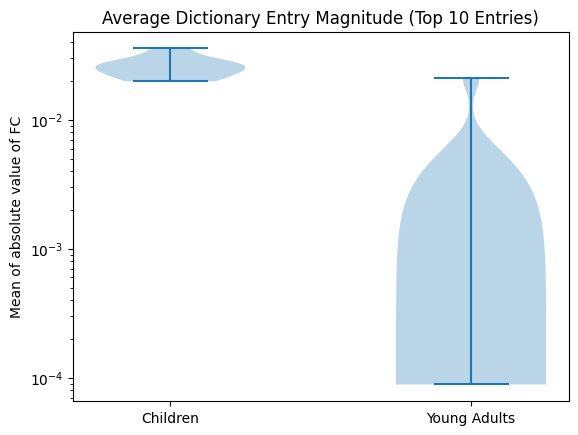

In [34]:
# Young children vs adults connectivity

fig, ax = plt.subplots()
ax.violinplot([botmag, topmag], [0,1])
ax.set_yscale('log')
ax.set_xticks([0,1], ['Children', 'Young Adults'])
ax.set_title('Average Dictionary Entry Magnitude (Top 10 Entries)')
ax.set_ylabel('Mean of absolute value of FC')
fig.show()
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/DynamicDict/Figures/mag-difference.pdf')

-0.14142589195309632


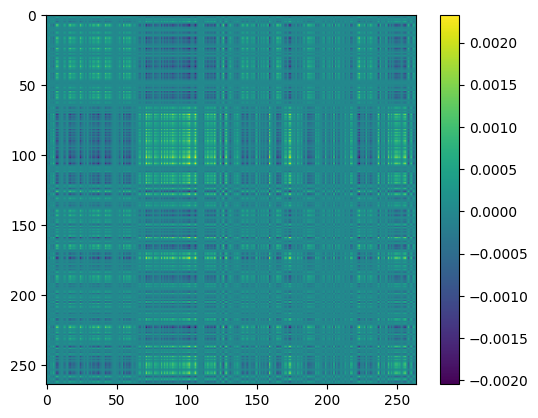

In [47]:
import matplotlib.pyplot as plt

idx = 182

print(sex_corr[idx])
plt.imshow(remap(book[idx].detach().cpu().numpy()))
plt.colorbar()
plt.show()

In [102]:
age_corr.min()

-0.2551586459329207